# Evaluation Of Duet Benchmarking Results from Distributed Database "Cassandra"

### Imports

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

### Import Benchmarking Measurements as csv file and create Pandas Dataframe for further Analysis

In [48]:
cwd = Path.cwd()
print(cwd)
filepath = os.path.join(cwd, "Results", "300_000ops_3t", "load_measurements.csv")
print(filepath)
df = pd.read_csv(filepath)

C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results
C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results\Results\300_000ops_3t\load_measurements.csv


### Insert latencies in ms into the measurement table

In [49]:
df["latency_ms"] = df["received"]- df["sent"]

### Restructure Timeline

In [50]:
firstSent = df["sent"].min()
df["sent_sec"] = (df["sent"] - firstSent)/1000

### Create Function to prune Measurements

In [67]:
def pruneMeasurements(dataframe): 
    print("Hello from the other side")
    
pruneMeasurements(df)


Hello from the other side


### Create subsets of dataframe (for Version A and B, and for each worker for Version A and B) 

In [51]:
dfA1 = df.loc[(df["workerId"] == "w1-vA")]
dfA2 = df.loc[(df["workerId"] == "w2-vA")]
dfA3 = df.loc[(df["workerId"] == "w3-vA")]
dfB1 = df.loc[(df["workerId"] == "w1-vB")]
dfB2 = df.loc[(df["workerId"] == "w2-vB")]
dfB3 = df.loc[(df["workerId"] == "w3-vB")]
dfA = df.loc[(df["workerId"] == "w1-vA") | (df["workerId"] == "w2-vA") | (df["workerId"] == "w3-vA")]
dfB = df.loc[(df["workerId"] == "w1-vB") | (df["workerId"] == "w2-vB") | (df["workerId"] == "w3-vB")]

### Return experiment run time (First request send to last response received)

In [52]:
totalTime = df["received"].max() - df["sent"].min()
print(totalTime/1000/60, "minuten")

24.5667 minuten


In [53]:
dfA1.describe()

,sent,received,latency_ms,sent_sec
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000
mean,1.657880e+12,1.657880e+12,42.035760,623.496011
std,4.297829e+05,4.297905e+05,57.254773,429.782864
min,1.657879e+12,1.657879e+12,3.000000,0.000000
25%,1.657879e+12,1.657879e+12,10.000000,214.230500
50%,1.657880e+12,1.657880e+12,15.000000,616.032000
75%,1.657880e+12,1.657880e+12,51.000000,1004.410500
max,1.657881e+12,1.657881e+12,1050.000000,1465.788000


In [54]:
dfB1.describe()

,sent,received,latency_ms,sent_sec
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000
mean,1.657880e+12,1.657880e+12,41.460180,621.590604
std,4.231760e+05,4.231828e+05,56.824203,423.175957
min,1.657879e+12,1.657879e+12,3.000000,0.000000
25%,1.657879e+12,1.657879e+12,10.000000,214.982000
50%,1.657880e+12,1.657880e+12,15.000000,620.875500
75%,1.657880e+12,1.657880e+12,50.000000,997.009750
max,1.657881e+12,1.657881e+12,1003.000000,1434.191000


### Min. Latencies for Worker 2 (A & B)

In [55]:
dfA2.loc[dfA2["latency_ms"].idxmin()]

workerId                                        w2-vA
queryType                                      INSERT
queryId          e211885c-beb4-4848-9317-f14e46874f49
sent                                    1657879198300
received                                1657879198303
target-region                            europe-west1
latency_ms                                          3
sent_sec                                       15.629
Name: 203787, dtype: object

In [56]:
dfB2.loc[dfB2["latency_ms"].idxmin()]

workerId                                        w2-vB
queryType                                      INSERT
queryId          4f0d1888-7a87-4b1d-9344-47c1dd726b3e
sent                                    1657879237176
received                                1657879237179
target-region                            europe-west1
latency_ms                                          3
sent_sec                                       54.505
Name: 214681, dtype: object

### Some checks

#### Time difference in ms when first query was sent by worker-1 to Version A and B 

In [57]:

dfA2["sent"].min() - dfB2["sent"].min()

2

#### Time difference in ms when last query was sent by worker-1 to Version A and B 

In [58]:
dfA1["sent"].max() - dfB1["sent"].max() 


31597

## Create Figures 

### Create Boxplots

In [59]:
sns.set_theme(style="darkgrid")

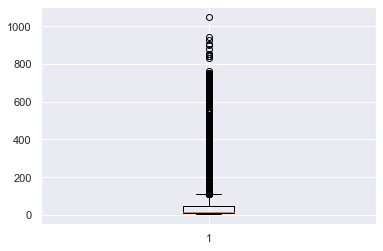

In [60]:
ax = plt.boxplot(x=dfA["latency_ms"])


### Create Flowchart

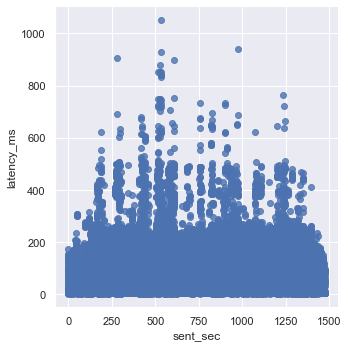

In [61]:
sns.lmplot(x='sent_sec', y='latency_ms', data=dfA, fit_reg=False)